## Car Price Estimation

Models used are:<br>
Decision Tree<br>
Random Forest<br>
Linear Model<br>
Support Vector Machine<br>

## Imports

In [33]:
import os
import datetime
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import plotly.io as pio
import cufflinks as cf
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams.update({"axes.grid" : False, "grid.color": "black"})

pd.options.plotting.backend = 'plotly'

pio.templates.default = "plotly"
cf.go_offline()


## Data import

In [6]:
df = pd.read_csv("preprocessedCarSwitch.csv", thousands=',')
df = df.replace('Bmw', "BMW")
df = df.where((df["year"] >= 2008) & (df["year"] <2019)).dropna()

## Saving for inference

In [7]:
brands = df.brand.unique()
colors = df.Color.unique()
specs = df.Specs.unique()

groups = df.groupby('brand')
sub_brands = {}
for group in groups.groups:
    sub_brands[group] = groups.get_group(group)['sub-brand'].unique()

In [8]:
groups = df.groupby(by=['brand', 'sub-brand'])
sub_brand_weights = {}
for group in groups.groups:
    sub_brand_weights[f'{group[0]}_{group[1]}'] = groups.get_group(group)['sub_brand_weight'].unique()[0]

## One Hot Encoding

In [9]:
#Create dummy variables for vcategorical features

color_dummies = pd.get_dummies(df["Color"])
specs_dummies = pd.get_dummies(df["Specs"])
brand_dummies = pd.get_dummies(df["brand"])
sub_brand_dummies = pd.get_dummies(df["sub-brand"])

df = pd.concat([df, brand_dummies, specs_dummies, color_dummies], axis=1)

df = df.sample(frac=1)
df = df.drop(["Color", "Specs", "sub-brand", "brand", 'brand_weight', 'overall-inc'], axis=1)

In [10]:
df.head()

,year,milage,no. of cylinders,price,sub_brand_weight,Audi,BMW,Cadillac,Chevrolet,Dodge,...,Burgundy,Gold,Green,Grey,Orange,Purple,Red,Silver,White,Yellow
203,2016.0,27000.0,5.0,50625.0,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
860,2013.0,161000.0,6.0,32000.0,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
914,2009.0,123000.0,4.0,15000.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
534,2013.0,56000.0,6.0,52500.0,2.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
689,2016.0,43000.0,4.0,82000.0,4.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## Correlation

In [11]:
# df.corr(method='kendall')['price'].sort_values(ascending=False).to_frame().T

In [12]:
df.corr(method='spearman')['price'].sort_values(ascending=False).to_frame().T

,price,sub_brand_weight,year,no. of cylinders,Porsche,BMW,Range,Maserati,Mercedes,Infiniti,...,Kia,Volkswagen,American,Chevrolet,Nissan,Mitsubishi,Silver,Peugeot,Renault,milage
price,1.0,0.729634,0.567019,0.401597,0.190109,0.185875,0.143461,0.142796,0.126535,0.097883,...,-0.094958,-0.097478,-0.097761,-0.100553,-0.105999,-0.115204,-0.137221,-0.14588,-0.157077,-0.520266


In [13]:
df.corr(method='pearson')['price'].sort_values(ascending=False).to_frame().T

,price,sub_brand_weight,year,no. of cylinders,Porsche,Range,BMW,European,Mercedes,Maserati,...,Red,Chevrolet,Mazda,Honda,Volkswagen,Peugeot,Renault,Mitsubishi,Silver,milage
price,1.0,0.686314,0.480926,0.411402,0.231652,0.202593,0.168136,0.162888,0.161856,0.137864,...,-0.082315,-0.082495,-0.083838,-0.088132,-0.094821,-0.100101,-0.109864,-0.116289,-0.120521,-0.46477


## Modeling

In [14]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# scaled_df = pd.dfFrame(scaler.fit_transform(tabular_df), columns=tabular_df.columns)

x = df.drop('price', axis=1)

scale = True

if scale:
    x = pd.DataFrame(x_scaler.fit_transform(x), columns=x.columns)
    y = pd.DataFrame(y_scaler.fit_transform(df[['price']]), columns=['price'])
else:
    x = pd.DataFrame(x, columns=x.columns)
    y = pd.DataFrame(df[['price']], columns=['price'])

shuffle = True
train_size = int(len(x)*0.8)

if shuffle:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
else:
    x_train, x_test, y_train, y_test = x[:train_size], x[train_size:], y[:train_size], y[train_size:]

lr = LR()
dt = DT()
rf = RF()
svr = SVR()

models = [lr, dt, rf, svr]
models_names = ['Linear Model', 'Decision Tree', 'Random Forest', 'SVM']

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

metrics = ['mean_absolute_error', 'r2_score', 'mean_squared_error']

train_scores = {}
test_scores = {}
model_preds = {}

test_df = y_test.copy()
train_df = y_train.copy()

In [15]:
for model, model_name in zip(models, models_names):
    model.fit(x_train, y_train)
    
    test_df[model_name] = model.predict(x_test).flatten()
    train_df[model_name] = model.predict(x_train).flatten()

    train_scores[model_name] = []
    test_scores[model_name] = []
    
    for metric in metrics:
        train_scores[model_name].append(eval(metric)(train_df[model_name], y_train))
        test_scores[model_name].append(eval(metric)(test_df[model_name], y_test))
        
test_df.sort_index(inplace=True)
train_df.sort_index(inplace=True)

In [16]:
test_scores = pd.DataFrame(test_scores, index = metrics)
train_scores = pd.DataFrame(train_scores, index = metrics)

In [17]:
if scale:
    for c in test_df:
        test_df[c] = y_scaler.inverse_transform(test_df[[c]]).flatten()

    for c in train_df:
        train_df[c] = y_scaler.inverse_transform(train_df[[c]]).flatten()

## Results

In [18]:
train_scores

,Linear Model,Decision Tree,Random Forest,SVM
mean_absolute_error,0.057816,2.446586e-05,0.015812,0.047572
r2_score,0.676855,9.999890e-01,0.964015,0.827509
mean_squared_error,0.006779,2.540964e-07,0.000699,0.003596


In [19]:
test_scores

,Linear Model,Decision Tree,Random Forest,SVM
mean_absolute_error,0.070305,0.058978,0.044071,0.053662
r2_score,0.650638,0.706511,0.766336,0.787023
mean_squared_error,0.009145,0.008404,0.005038,0.005437


In [20]:
pct_error = test_df.copy()
for c in pct_error:
    pct_error[f'{c}_error'] = round(abs(pct_error[c] - pct_error['price'])/pct_error['price'] * 100, 2)
pct_error.drop('price_error', axis=1, inplace=True)

In [21]:
pct_error

,price,Linear Model,Decision Tree,Random Forest,SVM,Linear Model_error,Decision Tree_error,Random Forest_error,SVM_error
1,32000.0,25113.281250,41000.0,37350.75,39376.774059,21.52,28.12,16.72,23.05
2,15000.0,-51567.382812,24500.0,19685.00,8164.315343,443.78,63.33,31.23,45.57
3,52500.0,64276.367187,45000.0,48259.00,54042.281096,22.43,14.29,8.08,2.94
6,130000.0,105414.062500,104000.0,105957.50,135919.023695,18.91,20.00,18.49,4.55
12,86000.0,88300.781250,83000.0,84282.50,105390.577377,2.68,3.49,2.00,22.55
...,...,...,...,...,...,...,...,...,...
1047,30000.0,4379.882812,44000.0,35782.25,49498.014204,85.40,46.67,19.27,64.99
1050,21500.0,19847.656250,21000.0,30733.00,19057.170167,7.69,2.33,42.94,11.36
1051,18000.0,-29188.476562,14000.0,15732.75,-5419.284535,262.16,22.22,12.60,130.11
1058,164000.0,122527.343750,85000.0,116994.50,148875.576381,25.29,48.17,28.66,9.22


## Average Percentage Error

In [22]:
pct_error.mean().iloc[-4:]

Linear Model_error     48.913709
Decision Tree_error    29.410282
Random Forest_error    22.175399
SVM_error              32.333052
dtype: float64

In [23]:
forest_error = pct_error['Random Forest_error']
forest_error = pd.cut(forest_error, range(0, int(forest_error.max()+2), 10), right=True, ).value_counts()

In [24]:
pct_error[['Random Forest_error']][:].plot()

## Actual vs Predicted

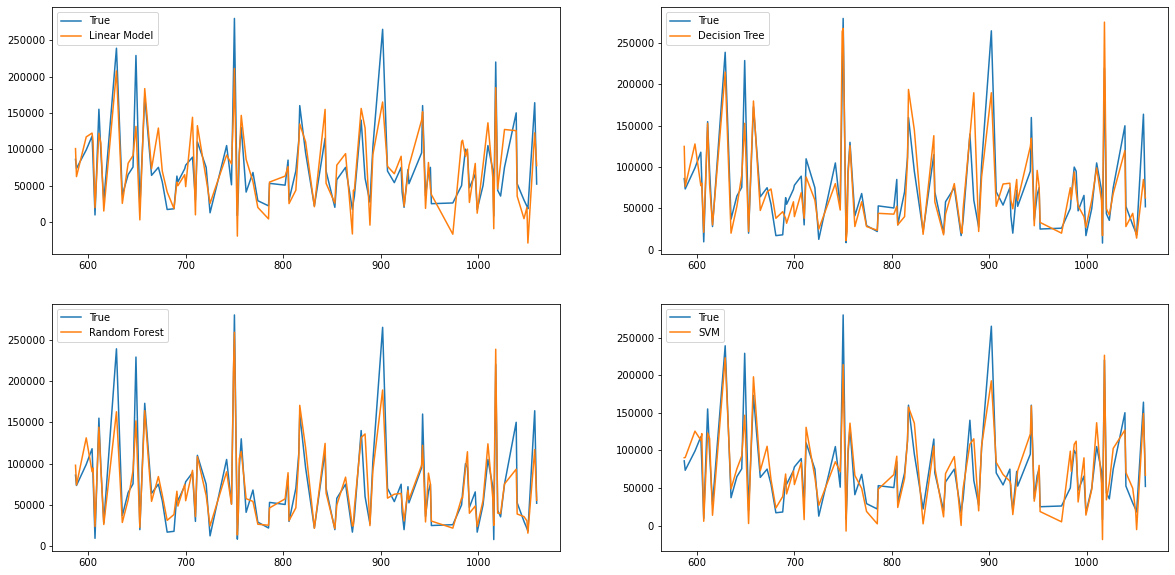

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.flatten()

for i, ax in zip(models_names, axs):
    ax.plot(test_df['price'][-100:], label='True')
    ax.plot(test_df[i][-100:], label=i)
    ax.legend(loc='upper left')

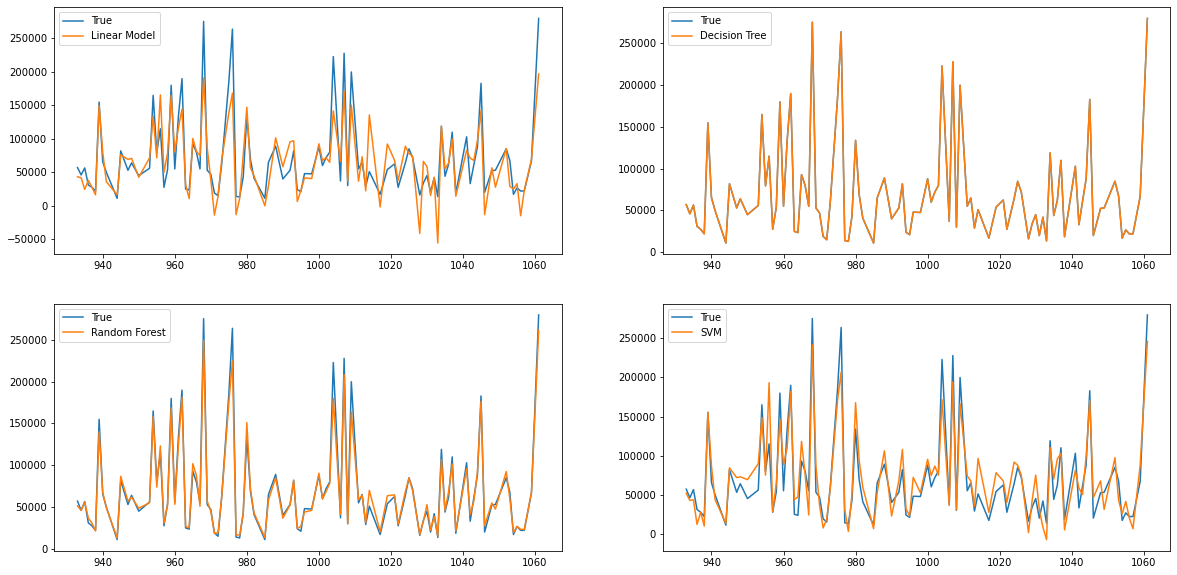

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.flatten()

for i, ax in zip(models_names, axs):
    ax.plot(train_df['price'][-100:], label='True')
    ax.plot(train_df[i][-100:], label=i)
    ax.legend(loc='upper left')

## Saving model and data for inference

In [28]:
pipe = Pipeline([('scaler', x_scaler), ('forest', rf)])

to_save = {'pipe':pipe, 'y_scaler':y_scaler, 'brands':brands, 'sub_brands':sub_brands, 'sub_brand_weights':sub_brand_weights, 'colors':colors, 'specs':specs}
import pickle
f = open('car_inference.pickle', 'wb')
pickle.dump(to_save, f)

## Model Inference

In [29]:
import pickle
import pandas as pd
import numpy as np

    
f = open('car_inference.pickle', 'rb')
dict_ = pickle.load(f)

brands = dict_['brands']
sub_brand_weights = dict_['sub_brand_weights']
colors = dict_['colors']
specs = dict_['specs']
y_scaler = dict_['y_scaler']
pipe = dict_['pipe']


def inference(brand, car_model, car_specs, year, milage, n_cylinder, color):

    model_weight = sub_brand_weights[f'{brand}_{car_model}']

    brand = pd.Categorical([brand], categories = brands)
    brand = pd.get_dummies(brand).values.flatten().tolist()

    car_specs = pd.Categorical([car_specs], categories = specs)
    car_specs = pd.get_dummies(car_specs).values.flatten().tolist()

    color = pd.Categorical([color], categories = colors)
    color = pd.get_dummies(color).values.flatten().tolist()

    test = [year, milage, n_cylinder, model_weight] + brand + car_specs + color
    test = np.array(test).flatten().reshape(1, -1)
    price = int(y_scaler.inverse_transform(pipe.predict(test).reshape(-1, 1)))

    return price

In [35]:
brand = 'Mazda'
car_model = '6 Ultra 2.5L'
car_specs = 'GCC'
year = 2015
milage = 160000
n_cylinder = 6
color = 'White'

price = inference(brand, car_model, car_specs, year, milage, n_cylinder, color)

price_len = len(str(price)) - 2

high = math.ceil(price / 10**price_len) * 10**price_len
low = math.floor(price / 10**price_len) * 10**price_len
price = f'{low:,} - {high:,} AED'

print(f'Estimated Car Price is: {price}')

Estimated Car Price is: 33,000 - 34,000 AED
